In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Sheet 2
- Benny Bauer
- Anton Schwarz

## 1 Bayes Theorem
We have
$$p(\gamma) = 0.1$$
$$p(b) = 0.9$$
with events $b$, $\gamma$ mutually exclusive.

Furthermore, we have
$$p(t|\gamma) = 0.95$$
$$p(t|b) = 0.1$$

We want to calculate $(\gamma|t)$. Using Bayes, we have
$$p(\gamma|t) = \frac{p(t|\gamma)p(\gamma)}{p(t)}$$

We realise that the only missing variable is $p(t)$, which is
$$p(t) = p(t|\gamma)p(\gamma) + p(t|b)p(b)$$

If we plug in the values given in the task, we get
$$p(\gamma|t) = 0.51$$

## 2 Trees and Random Forests
(a)

In [2]:
# load the data
pts = np.load('data02/data1d.npy')
labels = np.load('data02/labels1d.npy')

# TODO: Sort the points to easily split them
sort_inds = np.argsort(pts)
sorted_pts = pts[sort_inds]
sorted_labels = labels[sort_inds]

# TODO: Implement or find implementation for Gini impurity, entropy and misclassifcation rate
def splitter(labels: np.ndarray) -> tuple[int, int]:
    amt = len(labels)
    p0 = np.sum(labels == 0) / amt
    p1 = np.sum(labels == 1) / amt
    return p0, p1

def gini_impurity(labels: np.ndarray):
    p0, p1 = splitter(labels)
    return 1 - p0**2 - p1**2

def entropy_func(labels: np.ndarray):
    p0, p1 = splitter(labels)
    # remember that log2(x) = log(x) / log(2)
    if p0 == 0: return -p1 * np.log2(p1)
    if p1 == 0: return -p0 * np.log2(p0)
    return -p0 * np.log2(p0) - p1 * np.log2(p1)

def misclassification_rate(labels: np.ndarray, target: int):
    # number incorrect predictions / total number of predictions
    return len(labels[labels != target]) / len(labels)

# TODO: Iterate over the possible splits, evaulating and saving the three criteria for each one
output = []  # list of tuples (index, split, gini, entropy, misclass)
total_pts = len(pts)
for pivot in range(1, total_pts - 1):
    split = sorted_pts[pivot]
    left_labels = sorted_labels[:pivot]
    right_labels = sorted_labels[pivot:]
    # Use weighted average
    leftweight = pivot / total_pts
    rightweight = ((total_pts - pivot) / total_pts)
    gini = leftweight * gini_impurity(left_labels) + rightweight * gini_impurity(right_labels)
    entropy = leftweight * entropy_func(left_labels) + rightweight * entropy_func(right_labels)
    misclass = leftweight * misclassification_rate(left_labels, 0) + rightweight * misclassification_rate(right_labels, 1)
    output.append((pivot, split, gini, entropy, misclass))
    
# TODO: Compute the split that each criterion favours and visualize them 
#       (e.g. with a histogram for each class and vertical lines to show the splits)
outarray = np.array(output)
gini_min_split = np.argmin(outarray[:, 2])
entropy_min_split = np.argmin(outarray[:, 3])
misclass_min_split = np.argmin(outarray[:, 4])

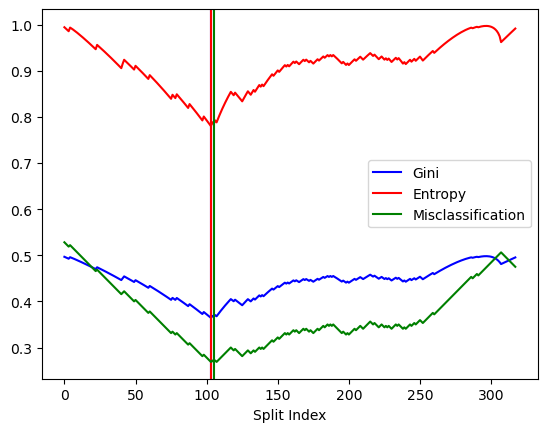

In [3]:
plt.plot(outarray[:,2], label="Gini", color="blue")
plt.axvline(gini_min_split, color="blue")
plt.plot(outarray[:,3], label="Entropy", color="red")
plt.axvline(entropy_min_split, color="red")
plt.plot(outarray[:,4], label="Misclassification", color="green")
plt.axvline(misclass_min_split, color="green")
plt.xlabel("Split Index")
plt.legend()

(b)

In [4]:
from sklearn.model_selection import train_test_split
# load the dijet data
features = np.load('data02/dijet_features_normalized.npy')
labels = np.load('data02/dijet_labels.npy')

# TODO: define train, val and test splits as specified (make sure to shuffle the data before splitting it!)
features_run, features_test, labels_run, labels_test = train_test_split(features.T, labels, train_size=0.9, shuffle=True)
features_train, features_val, labels_train, labels_val = train_test_split(features_run, labels_run, train_size=0.8, shuffle=False)
del features_run, labels_run

In [5]:
from sklearn.ensemble import RandomForestClassifier
from itertools import product

# TODO: train a random forest classifier for each combination of hyperparameters as specified on the sheet
#       and evaluate the performances on the validation set.
# hyperparams:
# [Num trees 5, 10, 20, 100] x [Split by Gini or Entropy] x [Depth of trees 2, 5, 10, pure]
bestparams = (5, "gini", 2)
score = 0
for (_numtrees, _splittype, _maxdepth) in product([5, 10, 20, 100], ["gini", "entropy"], [2, 5, 10, None]):
    clf = RandomForestClassifier(
        n_estimators=_numtrees, criterion=_splittype, max_depth=_maxdepth
    )
    clf.fit(features_train, labels_train)
    newscore = clf.score(features_val, labels_val)
    if newscore > score:
        score = newscore
        bestparams = (_numtrees, _splittype, _maxdepth)
    else:
        continue
print(f"The best score was {score:.3f} using params {bestparams}")

The best score was 0.794 using params (100, 'entropy', 10)


In [6]:
# TODO: for your preferred configuration, evaluate the performance of the best configuration on the test set
bestclf = RandomForestClassifier(
    n_estimators=bestparams[0], criterion=bestparams[1], max_depth=bestparams[2]
)
clf.fit(features_train, labels_train)
testscore = clf.score(features_test, labels_test)
print(f"The best set of hyperparameters scored {testscore:.3f} on the test dataset.")

The best set of hyperparameters scored 0.746 on the test dataset.


# 3) Fits

(a)
Excluding constant additive offsets and multiplicative factors, we get

$$\mathcal{L} = \sum_i\left(p_i - p(V_{m,i},\theta)\right)^2$$

(b)

We conclude that R=9.020.


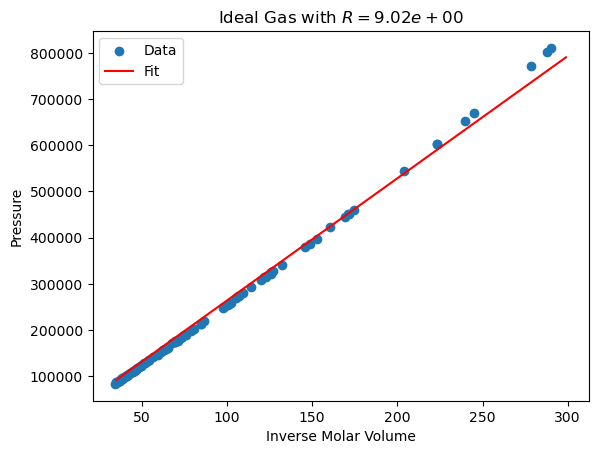

In [7]:
from scipy.optimize import minimize

data_Vm, data_p = np.load("data02/gas.npy")

# TODO: Implement the ideal gas law
def p_idealgas(V, n, R, T):
    return n * R * T / V

# TODO: Implement the negative log-likelihood
def objective(R, p, V):
    n = 1
    T = 293
    return np.sum(np.square(p - p_idealgas(V, n, R, T)))

# TODO: Perform the fit, print the results
res = minimize(objective, [1], args=(data_p, data_Vm))
R = res.x[0]
print(f"We conclude that R={R:.3f}.")  # Question: How to get uncertainty!?

# TODO: Visualize your results
inverse_v_range = np.arange(35, 300)
plt.title(f"Ideal Gas with $R={R:.2e}$")
plt.scatter(1/data_Vm, data_p, label="Data")
plt.plot(inverse_v_range, p_idealgas(1/inverse_v_range, 1, R, 293), label="Fit", color="red")
plt.xlabel("Inverse Molar Volume")
plt.ylabel("Pressure")
plt.legend()

(c)

We conclude that a=-4.50e+00 and b=-2.59e-03.


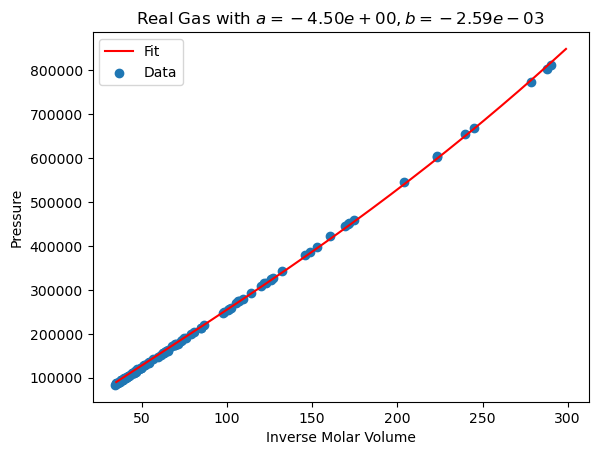

In [8]:
# TODO: Implement the real gas law
def p_realgas(V, R, T, a, b):
    return R*T/(V - b) - a/np.square(V)

# TODO: Implement the negative log-likelihood
def objective_real(x, p, V, R):
    T = 293
    return np.sum(np.square(p - p_realgas(V, R, T, x[0], x[1])))

# TODO: Perform the fit, print the results
res_real = minimize(objective_real, [1, 1], args=(data_p, data_Vm, R))
[a, b] = res_real.x
print(f"We conclude that a={a:.2e} and b={b:.2e}.")  # Question: How to get uncertainty!?

# TODO: Visualize your results
plt.title(f"Real Gas with $a={a:.2e}, b={b:.2e}$")
plt.plot(inverse_v_range, p_realgas(1/inverse_v_range, R, 293, a, b), label="Fit", color="red")
plt.scatter(1/data_Vm, data_p, label="Data")
plt.xlabel("Inverse Molar Volume")
plt.ylabel("Pressure")
plt.legend()